## 0. Introduction

Ce projet est réalisé par Zakarya El Mimouni et Yassine Boukhateb étudiants en deuxième année du cycle ingénieur de l'ENSAE Paris dans le cadre du cours de Python pour la DataScience.

**Importation des modules et packages**

In [36]:
import requests
import json
import time
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import matplotlib.pyplot as plt

## I. Récupération des données

On récupère les données de 10 000 films grâce à l'API TMDB

On récupère les données qui nous seront utile pour la création de l'interface de l'application.

In [4]:
movies_data=pd.read_json('movies_data_complete.json')

In [69]:

list(movies_data.columns)

['adult',
 'backdrop_path',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'credits',
 'keywords']

In [9]:
movies_data.isna().sum()

adult                       0
backdrop_path              78
belongs_to_collection    7422
budget                      0
genres                      0
homepage                    0
id                          0
imdb_id                    42
original_language           0
original_title              0
overview                    0
popularity                  0
poster_path                 4
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                     0
title                       0
video                       0
vote_average                0
vote_count                  0
credits                     0
keywords                    0
dtype: int64

la colonnes "belongs_to_collection" comporte le plus de valuer manquantes et il est pas intéressante pour notre cas, on va donc l'éliminer

In [10]:
movies_data=movies_data.drop(columns=['belongs_to_collection'])

In [12]:
movies_data.isna().sum()

adult                    0
backdrop_path           78
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                 42
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              4
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
credits                  0
keywords                 0
dtype: int64

élimination des lignes avec des valeurs manquantes

In [16]:
movies_data.dropna(inplace=True)

In [17]:
movies_data.isna().sum()

adult                   0
backdrop_path           0
budget                  0
genres                  0
homepage                0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              0
poster_path             0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
video                   0
vote_average            0
vote_count              0
credits                 0
keywords                0
dtype: int64

il n'y a plus de valeurs manquante

# supprimer les films dupliqués

In [25]:
movies_data= movies_data.drop_duplicates(subset='title', keep='first')

# étude de la base de données 

In [28]:
movies_data['genres']

0       [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...
1       [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
2       [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...
3       [{'id': 16, 'name': 'Animation'}, {'id': 10751...
4       [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
                              ...                        
9994                       [{'id': 35, 'name': 'Comedy'}]
9995    [{'id': 12, 'name': 'Adventure'}, {'id': 18, '...
9997    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
9998    [{'id': 10402, 'name': 'Music'}, {'id': 18, 'n...
9999    [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...
Name: genres, Length: 8890, dtype: object

In [30]:
movies_data.loc[0].genres

[{'id': 80, 'name': 'Crime'},
 {'id': 18, 'name': 'Drama'},
 {'id': 36, 'name': 'History'}]

on va mettre cette colonnes de façon plus lisible

In [31]:
def convert(text):
    L = []
    for i in text:
        L.append(i["name"]) 
    return L 

In [32]:
movies_data['genres'] = movies_data['genres'].apply(convert)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8668\3427741029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_data['genres'] = movies_data['genres'].apply(convert)


In [72]:
movies_data.loc[0].production_countries

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [73]:
movies_data['production_countries'] = movies_data['production_countries'].apply(convert)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8668\595673310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_data['production_countries'] = movies_data['production_countries'].apply(convert)


In [74]:
movies_data['production_countries'] 

0                       [United States of America]
1                       [United States of America]
2       [United Kingdom, United States of America]
3                       [United States of America]
4            [Australia, United States of America]
                           ...                    
9994                    [United States of America]
9995                    [United States of America]
9997                    [United States of America]
9998                    [United States of America]
9999            [Canada, United States of America]
Name: production_countries, Length: 8890, dtype: object

In [37]:
genres_exploded = movies_data['genres'].explode()
# Compter le nombre de films par genre
genre_counts = genres_exploded.value_counts()
print("Nombre de films par genre :")
print(genre_counts)

Nombre de films par genre :
Drama              3601
Comedy             2845
Thriller           2392
Action             2388
Adventure          1623
Romance            1403
Horror             1333
Crime              1221
Family             1193
Science Fiction    1141
Fantasy            1140
Animation          1075
Mystery             821
History             394
War                 318
Music               237
TV Movie            202
Western             185
Documentary          91
Name: genres, dtype: int64


In [41]:
genres_exploded.head(20)

0              Crime
0              Drama
0            History
1             Action
1             Comedy
2             Comedy
2             Family
2            Fantasy
3          Animation
3             Family
3              Music
3            Fantasy
3             Comedy
4          Animation
4             Comedy
4             Family
5              Drama
5            Mystery
5           Thriller
5    Science Fiction
Name: genres, dtype: object

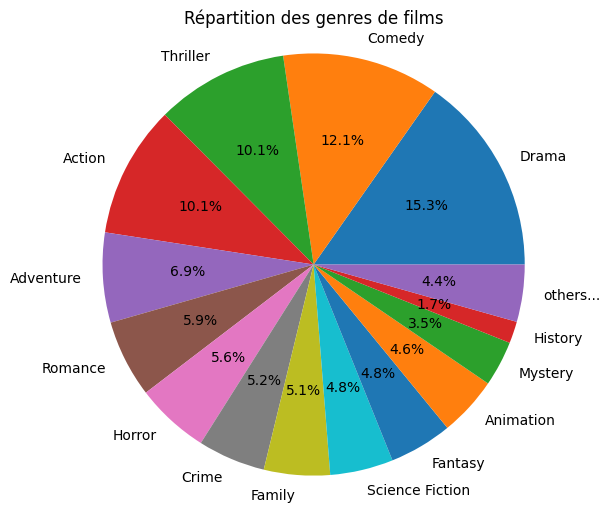

In [96]:
totale=genre_counts.sum()
list_principale=list(genre_counts[:14])
list_principale.append(totale-sum(list_principale))
list_genre=list(genre_counts[:14].index)
list_genre.append('others...')
plt.figure(figsize=(6, 6))
plt.pie(list_principale, labels=list_genre, autopct='%1.1f%%')
plt.title('Répartition des genres de films')
plt.axis('equal')  
plt.show()

# Pays Producteurs

In [76]:
pays_exploded = movies_data['production_countries'] .explode()
# Compter le nombre de films par genre
pays_counts = pays_exploded.value_counts()
print("Nombre de films par pays :")
print(pays_counts)

Nombre de films par pays :
United States of America    6724
United Kingdom              1246
France                       707
Canada                       610
Japan                        521
                            ... 
Georgia                        1
Bolivia                        1
Latvia                         1
Iraq                           1
Liechtenstein                  1
Name: production_countries, Length: 97, dtype: int64


In [78]:
pays_counts[:15]

United States of America    6724
United Kingdom              1246
France                       707
Canada                       610
Japan                        521
Germany                      454
Italy                        240
Spain                        199
China                        177
Australia                    166
South Korea                  145
Hong Kong                    138
Belgium                      136
Mexico                        90
Ireland                       89
Name: production_countries, dtype: int64

In [82]:
pays_counts.sum()

12709

In [80]:
list_principale=pays_counts[:16]
list_principale.sum()

11725

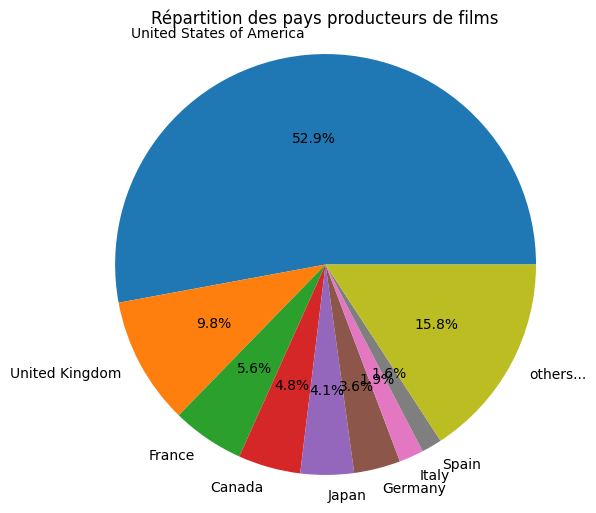

In [93]:
totale=pays_counts.sum()
list_principale=list(pays_counts[:8])
list_principale.append(totale-sum(list_principale))
list_pays=list(pays_counts[:8].index)
list_pays.append('others...')
plt.figure(figsize=(6, 6))
plt.pie(list_principale, labels=list_pays, autopct='%1.1f%%')
plt.title('Répartition des pays producteurs de films')
plt.axis('equal')  
plt.show()

# Genres et Budget

In [48]:
top_5_expensive_movies =movies_data.nlargest(5, 'budget')

In [49]:
top_5_expensive_movies.head()

,adult,backdrop_path,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits,keywords
56,False,/8rpDcsfLJypbO6vREc0547VKqEv.jpg,460000000,"[Science Fiction, Adventure, Action]",https://www.avatar.com/movies/avatar-the-way-o...,76600,tt1630029,en,Avatar: The Way of Water,Set more than a decade after the events of the...,...,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.651,10365,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 3737, 'name': 'dying and ..."
298,False,/wQ0r0JRs7elHSKg1SFtdWdKTYKi.jpg,379000000,"[Adventure, Action, Fantasy]",https://movies.disney.com/pirates-of-the-carib...,1865,tt1298650,en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,...,137,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Live Forever Or Die Trying.,Pirates of the Caribbean: On Stranger Tides,False,6.540,13290,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 658, 'name': 'sea'}, {'id..."
426,False,/6YwkGolwdOMNpbTOmLjoehlVWs5.jpg,365000000,"[Action, Adventure, Science Fiction]",http://marvel.com/movies/movie/193/avengers_ag...,99861,tt2395427,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,...,141,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A new age has come.,Avengers: Age of Ultron,False,7.274,21979,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 310, 'name': 'artificial ..."
335,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,356000000,"[Adventure, Science Fiction, Action]",https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,en,Avengers: Endgame,After the devastating events of Avengers: Infi...,...,181,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Avenge the fallen.,Avengers: Endgame,False,8.261,24185,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 9715, 'name': 'superhero'..."
15,False,/4XM8DUTQb3lhLemJC51Jx4a2EuA.jpg,340000000,"[Action, Crime, Thriller]",https://fastxmovie.com,385687,tt5433140,en,Fast X,Over many missions and against impossible odds...,...,142,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The end of the road begins.,Fast X,False,7.200,4484,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 9663, 'name': 'sequel'}, ..."


In [70]:
movies_data.production_countries

0       [{'iso_3166_1': 'US', 'name': 'United States o...
1       [{'iso_3166_1': 'US', 'name': 'United States o...
2       [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...
3       [{'iso_3166_1': 'US', 'name': 'United States o...
4       [{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...
                              ...                        
9994    [{'iso_3166_1': 'US', 'name': 'United States o...
9995    [{'iso_3166_1': 'US', 'name': 'United States o...
9997    [{'iso_3166_1': 'US', 'name': 'United States o...
9998    [{'iso_3166_1': 'US', 'name': 'United States o...
9999    [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...
Name: production_countries, Length: 8890, dtype: object

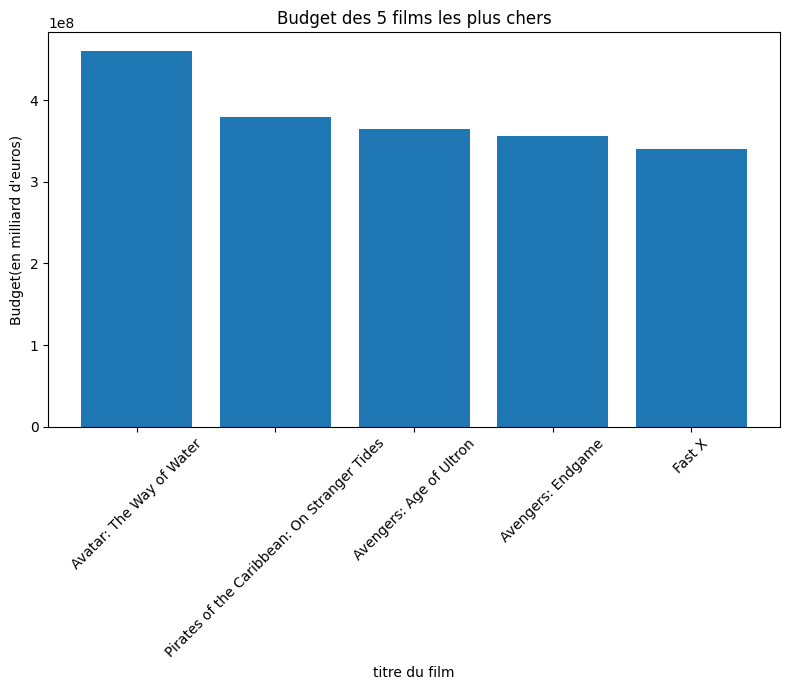

In [58]:
plt.figure(figsize=(8, 7))
plt.bar(range(len(top_5_expensive_movies)), top_5_expensive_movies['budget'])
plt.xlabel('titre du film')
plt.ylabel("Budget(en milliard d'euros)")
plt.title('Budget des 5 films les plus chers')
plt.xticks(range(len(top_5_expensive_movies)), top_5_expensive_movies['title'], rotation=45)
plt.tight_layout()
plt.show()

# Moyenne du budget par catégorie du film

In [57]:
genres_with_budget = movies_data.explode('genres')[['genres', 'budget']]
# Calcul de la moyenne des budgets par genre
average_budget_by_genre = genres_with_budget.groupby('genres')['budget'].mean()
print("Moyenne des budgets par genre :")
print(average_budget_by_genre)

Moyenne des budgets par genre :
genres
Action             3.703105e+07
Adventure          4.991111e+07
Animation          2.329480e+07
Comedy             2.190220e+07
Crime              2.175015e+07
Documentary        1.178846e+06
Drama              1.679477e+07
Family             3.259011e+07
Fantasy            3.667179e+07
History            2.539565e+07
Horror             9.286637e+06
Music              1.600934e+07
Mystery            1.771753e+07
Romance            1.532880e+07
Science Fiction    3.742086e+07
TV Movie           8.499553e+05
Thriller           2.058452e+07
War                2.306122e+07
Western            1.578088e+07
Name: budget, dtype: float64


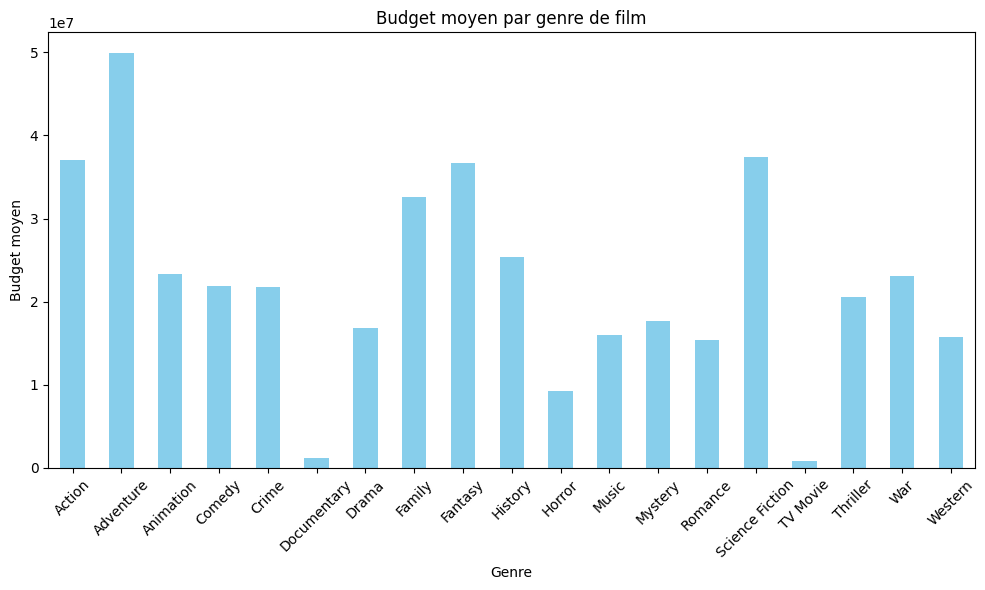

In [59]:
plt.figure(figsize=(10, 6))
average_budget_by_genre.plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Budget moyen')
plt.title('Budget moyen par genre de film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Langue et Film

In [62]:
movies_data['original_language'].unique()

array(['en', 'ko', 'no', 'fr', 'ja', 'es', 'ar', 'mn', 'zh', 'uk', 'hi',
       'tl', 'de', 'fi', 'th', 'nl', 'pt', 'id', 'it', 'pl', 'te', 'sv',
       'ru', 'ml', 'is', 'ca', 'cn', 'da', 'tr', 'yo', 'el', 'ig', 'sr',
       'ta', 'cs', 'mk', 'bn', 'hr', 'km', 'ga', 'nb', 'he', 'ro', 'hu',
       'vi'], dtype=object)

# Nombre de Film Par Langue

In [66]:
langues_exploded = movies_data['original_language'].explode()
# Compter le nombre de films par genre
langues_counts = langues_exploded.value_counts()
print("Nombre de films par langue :")
print(langues_counts)

Nombre de films par langue :
en    7391
ja     410
fr     251
es     171
ko     119
it     115
zh      67
de      59
cn      51
ru      31
da      24
no      24
sv      22
hi      19
nl      17
pt      17
pl      17
tl      12
th      11
id       8
fi       8
te       6
ar       4
tr       4
cs       3
is       3
sr       3
ta       2
el       2
ca       2
uk       2
km       2
he       1
ro       1
hu       1
nb       1
ga       1
yo       1
hr       1
bn       1
mk       1
ig       1
ml       1
mn       1
vi       1
Name: original_language, dtype: int64


on représente le nombre de film par langue sur une échelle logarithmique 

<AxesSubplot:>

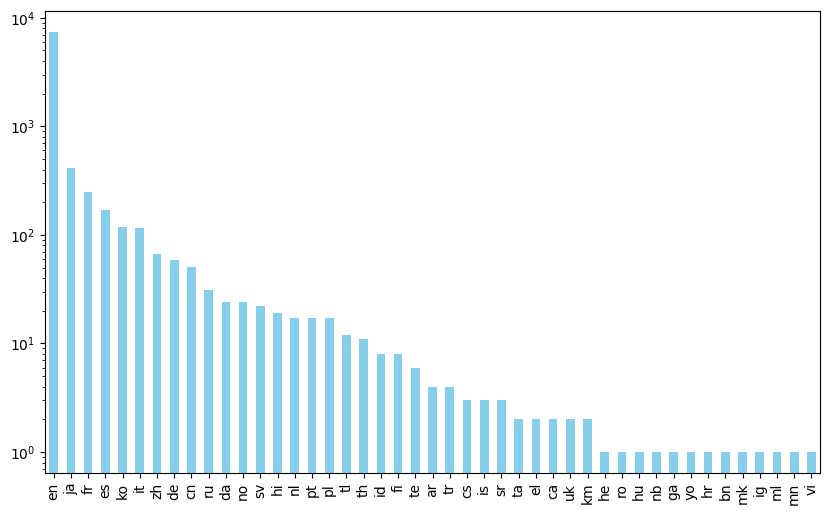

In [97]:
plt.figure(figsize=(10, 6))
langues_counts.plot(kind='bar', color='skyblue',logy=True)

# Budget Et Langue De Film

In [63]:
budget_film_by_language = movies_data.groupby('original_language')['budget'].mean()


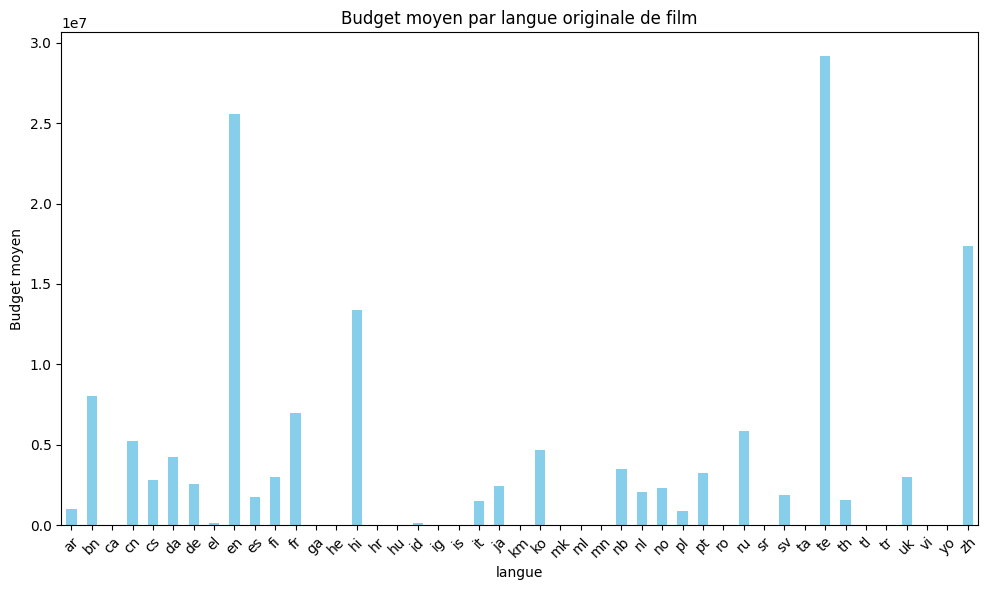

In [64]:
plt.figure(figsize=(10, 6))
budget_film_by_language.plot(kind='bar', color='skyblue')
plt.xlabel('langue')
plt.ylabel('Budget moyen')
plt.title('Budget moyen par langue originale de film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

te ? cette langue a seulement 6 films mais en moyenne il dépense plus de 3 milliard d'euro pour chque film

# Sélectionner les colonnes intéressantes

In [3]:

selected_columns=['id','title','original_title','overview','release_date','adult','popularity','vote_average','vote_count','poster_path','runtime','genres','production_companies','production_countries','spoken_languages','credits','keywords']
movies_data=movies_data[selected_columns]
movies_data= movies_data.drop_duplicates(subset='title', keep='first')

In [36]:
# Convertir la colonne 'release_date' en type datetime si ce n'est pas déjà le cas
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])

# Filtrer les films dont la date est antérieure à '2023-10-18'
movies_data = movies_data[movies_data['release_date'] <= '2023-12-31']
movies_data.reset_index(drop=True)
movies_data.dropna(axis=0,inplace=True)

On contrôle qu'il n'y pas de variables avec des informations manquantes. On fait le choix d'enlever le film dès lors qu'il manque une info c'est assez restrictif A FAIRE PLUS TARD

Pour notre modèle on conserve que les films dont les features ci dessous existent ça sera plus crédible

In [38]:
movies_reco=movies_data[["id","title","overview","genres","keywords","credits"]]
display(movies_reco.loc[0].genres,
movies_data.loc[0].keywords["keywords"][0],
movies_data.loc[0].credits["cast"][0])

[{'id': 80, 'name': 'Crime'},
 {'id': 18, 'name': 'Drama'},
 {'id': 36, 'name': 'History'}]

{'id': 1157, 'name': 'husband wife relationship'}

{'adult': False,
 'gender': 2,
 'id': 6193,
 'known_for_department': 'Acting',
 'name': 'Leonardo DiCaprio',
 'original_name': 'Leonardo DiCaprio',
 'popularity': 56.044,
 'profile_path': '/5Brc5dLifH3UInk3wUaCuGXpCqy.jpg',
 'cast_id': 0,
 'character': 'Ernest Burkhart',
 'credit_id': '5968f416c3a3686f60021bc8',
 'order': 0}

On nettoie les colonnes genres, keywords, credits

In [39]:
def convert(text):
    L = []
    for i in text:
        L.append(i["name"]) 
    return L 


In [40]:
movies_reco['genres'] = movies_reco['genres'].apply(convert)
movies_reco['keywords'] = movies_reco['keywords'].apply(lambda x: x['keywords'] if isinstance(x, dict) and 'keywords' in x else None) # regarder Robot Apocalypse Keywords
movies_reco = movies_reco[movies_reco['keywords'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
movies_reco["keywords"]=movies_reco["keywords"].apply(convert)

movies_reco['cast'] = movies_reco['credits'].apply(lambda x: x.get('cast') if isinstance(x, dict) else None)
movies_reco['crew'] = movies_reco['credits'].apply(lambda x: x.get('crew') if isinstance(x, dict) else None)
movies_reco.drop("credits", axis=1,inplace=True)
movies_reco.head()

W:\AppData\Local\Temp\ipykernel_11172\1391644150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['genres'] = movies_reco['genres'].apply(convert)
W:\AppData\Local\Temp\ipykernel_11172\1391644150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['keywords'] = movies_reco['keywords'].apply(lambda x: x['keywords'] if isinstance(x, dict) and 'keywords' in x else None) # regarder Robot Apocalypse Keywords


,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husband wife relationship, based on novel or ...","[{'adult': False, 'gender': 2, 'id': 6193, 'kn...","[{'adult': False, 'gender': 2, 'id': 27, 'know..."
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coup d'etat, dictatorship, political assassin...","[{'adult': False, 'gender': 2, 'id': 56446, 'k...","[{'adult': True, 'gender': 2, 'id': 997, 'know..."
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[{'adult': False, 'gender': 2, 'id': 1190668, ...","[{'adult': False, 'gender': 2, 'id': 1299, 'kn..."
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[pop star, brother, musical, sequel, based on ...","[{'adult': False, 'gender': 1, 'id': 84223, 'k...","[{'adult': False, 'gender': 2, 'id': 10572, 'k..."
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucket list]","[{'adult': False, 'gender': 2, 'id': 19292, 'k...","[{'adult': False, 'gender': 0, 'id': 7963, 'kn..."


In [42]:
def convert3(text):
    L=[]
    counter=0
    for i in text:
        if counter<3:
            L.append(i["name"])
        counter+=1
    return L
movies_reco["cast"]=movies_reco["cast"].apply(convert3)

Ainsi, les colonnes genres, keywords, cast et crew sont exploitables.

In [45]:
def fetch_director(text):
    L = []
    for i in text:
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L 
movies_reco["crew"]=movies_reco["crew"].apply(fetch_director)
movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
movies_reco.head()

,id,title,overview,genres,keywords,cast,crew,title_bis
0,466420,Killers of the Flower Moon,"[When, oil, is, discovered, in, 1920s, Oklahom...","[Crime, Drama, History]","[husband wife relationship, based on novel or ...","[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese],"[Killers, of, the, Flower, Moon]"
1,897087,Freelance,"[An, ex-special, forces, operative, takes, a, ...","[Action, Comedy]","[coup d'etat, dictatorship, political assassin...","[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel],[Freelance]
2,787699,Wonka,"[Willy, Wonka, –, chock-full, of, ideas, and, ...","[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King],[Wonka]
3,901362,Trolls Band Together,"[When, Branch's, brother,, Floyd,, is, kidnapp...","[Animation, Family, Music, Fantasy, Comedy]","[pop star, brother, musical, sequel, based on ...","[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn],"[Trolls, Band, Together]"
4,1075794,Leo,"[Jaded, 74-year-old, lizard, Leo, has, been, s...","[Animation, Comedy, Family]","[classroom, musical, bucket list]","[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel],[Leo]


In [46]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1
movies_reco['cast'] = movies_reco['cast'].apply(collapse)
movies_reco['crew'] = movies_reco['crew'].apply(collapse)
movies_reco['genres'] = movies_reco['genres'].apply(collapse)
movies_reco['keywords'] = movies_reco['keywords'].apply(collapse)
movies_reco.head()

,id,title,overview,genres,keywords,cast,crew,title_bis
0,466420,Killers of the Flower Moon,"[When, oil, is, discovered, in, 1920s, Oklahom...","[Crime, Drama, History]","[husbandwiferelationship, basedonnovelorbook, ...","[LeonardoDiCaprio, LilyGladstone, RobertDeNiro]",[MartinScorsese],"[Killers, of, the, Flower, Moon]"
1,897087,Freelance,"[An, ex-special, forces, operative, takes, a, ...","[Action, Comedy]","[coupd'etat, dictatorship, politicalassassinat...","[JohnCena, AlisonBrie, JuanPabloRaba]",[PierreMorel],[Freelance]
2,787699,Wonka,"[Willy, Wonka, –, chock-full, of, ideas, and, ...","[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[TimothéeChalamet, CalahLane, Keegan-MichaelKey]",[PaulKing],[Wonka]
3,901362,Trolls Band Together,"[When, Branch's, brother,, Floyd,, is, kidnapp...","[Animation, Family, Music, Fantasy, Comedy]","[popstar, brother, musical, sequel, basedontoy...","[AnnaKendrick, JustinTimberlake, CamilaCabello]",[WaltDohrn],"[Trolls, Band, Together]"
4,1075794,Leo,"[Jaded, 74-year-old, lizard, Leo, has, been, s...","[Animation, Comedy, Family]","[classroom, musical, bucketlist]","[AdamSandler, BillBurr, CecilyStrong]",[RobertSmigel],[Leo]


In [47]:
movies_reco['label'] = movies_reco['overview']+movies_reco['title_bis']+movies_reco['genres'] + movies_reco['keywords'] + movies_reco['cast'] + movies_reco['crew']
data_model=movies_reco.drop(columns=['overview','genres','keywords','cast','crew',"title_bis"])
data_model['label'] = data_model['label'].apply(lambda x: " ".join(x))
data_model.head()

,id,title,label
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...
1,897087,Freelance,An ex-special forces operative takes a job to ...
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for..."
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...


In [48]:
ps =PorterStemmer()
def stem(text): # stem("dancing")=>"danc"
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
data_model["label"]=data_model["label"].apply(stem)
data_model["label"]=data_model["label"].apply(lambda x : x.lower())
data_model.head()

,id,title,label
0,466420,Killers of the Flower Moon,when oil is discov in 1920 oklahoma under osag...
1,897087,Freelance,an ex-speci forc oper take a job to provid sec...
2,787699,Wonka,willi wonka – chock-ful of idea and determin t...
3,901362,Trolls Band Together,"when branch' brother, floyd, is kidnap for hi ..."
4,1075794,Leo,jade 74-year-old lizard leo ha been stuck in t...


In [49]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8302 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8302 non-null   int64 
 1   title   8302 non-null   object
 2   label   8302 non-null   object
dtypes: int64(1), object(2)
memory usage: 259.4+ KB


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(data_model['label']).toarray()

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.        , 0.        , ..., 0.01690309, 0.06172134,
        0.        ],
       [0.        , 1.        , 0.03846154, ..., 0.09376145, 0.        ,
        0.03580574],
       [0.        , 0.03846154, 1.        , ..., 0.02344036, 0.0855921 ,
        0.10741723],
       ...,
       [0.01690309, 0.09376145, 0.02344036, ..., 1.        , 0.02608203,
        0.04364358],
       [0.06172134, 0.        , 0.0855921 , ..., 0.02608203, 1.        ,
        0.        ],
       [0.        , 0.03580574, 0.10741723, ..., 0.04364358, 0.        ,
        1.        ]])

In [52]:
similarity.shape

(8302, 8302)

In [53]:
def recommend(movie,m):
    index = data_model[data_model['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:m+1]:
        print(data_model.iloc[i[0]].title)

In [54]:
recommend("Killers of the Flower Moon",2)

Wind River
Thunderheart


In [55]:
import pickle
pickle.dump(data_model.to_dict(),open("movies_dict.pkl","wb"))
pickle.dump(similarity,open("similarity.pkl","wb"))